# Data Processing

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

import gym
from gym_anytrading.envs import StocksEnv
from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv

In [6]:
import pandas as pd

df = pd.read_csv("apple.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2/25/2022,163.84,165.12,160.87,164.85,"91,974,227"
1,2/24/2022,152.58,162.85,152.00,162.74,"141,147,500"
2,2/23/2022,165.54,166.15,159.75,160.07,"90,009,250"
3,2/22/2022,164.98,166.69,162.15,164.32,"91,162,758"
4,2/18/2022,169.82,170.54,166.19,167.30,"82,772,672"


In [10]:
df["sectionId"] = df["sections"].split("sectionId")

163.84

In [ ]:
for number in range(1,79):
    inputfile = "filename" + str(number) + ".json"
    outputfile = "filename" + str(number) + ".csv"
    
    pd.read_json(inputfile).to_csv(outputfile)



In [32]:
string = "filename" + str(46) + ".json"
string

'filename46.json'

In [ ]:
df = pd.read_csv("apple.csv")

In [20]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2/25/2022,163.84,165.12,160.87,164.85,"91,974,227"
1,2/24/2022,152.58,162.85,152.00,162.74,"141,147,500"
2,2/23/2022,165.54,166.15,159.75,160.07,"90,009,250"
3,2/22/2022,164.98,166.69,162.15,164.32,"91,162,758"
4,2/18/2022,169.82,170.54,166.19,167.30,"82,772,672"


In [20]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [21]:
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", ascending=True, inplace=True)
df.set_index("Date", inplace=True)
df["Volume"] = df["Volume"].apply(lambda x: float(x.replace(",", "")))
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-02-25,43.54,43.97,43.49,43.56,87493436.0
2019-02-26,43.43,43.83,43.29,43.58,68280844.0
2019-02-27,43.30,43.75,43.18,43.72,111341564.0
2019-02-28,43.58,43.73,43.23,43.29,112861680.0
2019-03-01,43.57,43.79,43.22,43.74,103544680.0


In [22]:
df["SMA"] = TA.SMA(df, 12)
df["RSI"] = TA.RSI(df)
df["OBV"] = TA.OBV(df)
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2019-02-25,43.54,43.97,43.49,43.56,87493436.0,0.0,0.00000,0.0
2019-02-26,43.43,43.83,43.29,43.58,68280844.0,0.0,100.00000,68280844.0
2019-02-27,43.30,43.75,43.18,43.72,111341564.0,0.0,100.00000,179622408.0
2019-02-28,43.58,43.73,43.23,43.29,112861680.0,0.0,25.50822,66760728.0
2019-03-01,43.57,43.79,43.22,43.74,103544680.0,0.0,59.50503,170305408.0


In [23]:
window_frame = 30

all_frame = (window_frame, len(df))
# train_frame = (window_frame,int(len(df)*0.7))
train_frame = (int(len(df)*0.33),int(len(df)*0.7))
test_frame = (int(len(df)*0.7),int(len(df)))
train_steps = 10000

In [24]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, "Low"].to_numpy()[start:end]
    signal_features = env.df.loc[:, ["Open", "High", "Low", "Close", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end] # Can add more features
#     signal_features = env.df.loc[:, ["Low", "Volume", "SMA", "RSI", "OBV"]].to_numpy()[start:end] # Can add more features
    return prices, signal_features

In [25]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env = MyCustomEnv(df=df, window_size=window_frame, frame_bound=train_frame)
states = env.observation_space.shape
actions = env.action_space.n

# Deep Learning Model with Keras

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM,Reshape

In [27]:
def build_model(states, actions):
    model = Sequential()
    
    model.add(Flatten(input_shape=(1,) + states))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(actions, activation="linear"))
    
    
    model.compile(optimizer='adam',loss='mean_squared_error')


    
    return model

In [28]:
model = build_model(states, actions)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 240)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               123392    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 533,954
Trainable params: 533,954
Non-tr

# Keras-RL Agent

In [30]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.policy import GreedyQPolicy
from rl.memory import SequentialMemory

In [31]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
#     policy = GreedyQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [32]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=train_steps, visualize=False, verbose=0)

C:\Users\jacky\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\jacky\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\jacky\anaconda3\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


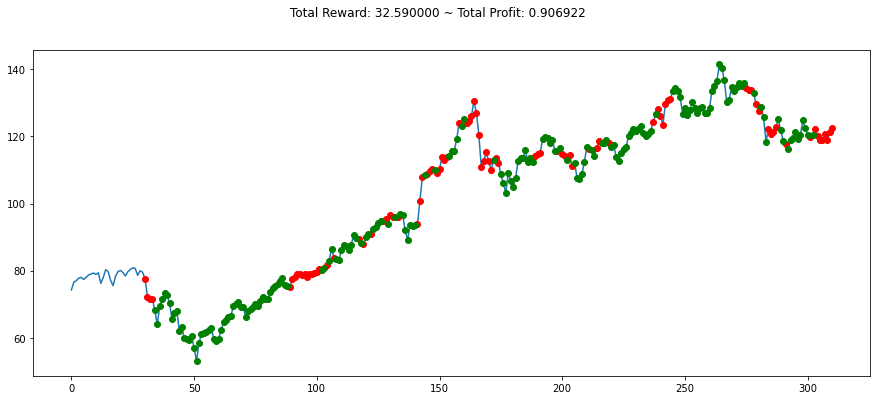

In [33]:
# Train Set Evaluation
env = MyCustomEnv(df=df, window_size=window_frame, frame_bound=train_frame)
dqn.test(env, nb_episodes=1, visualize=False, verbose=0)

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

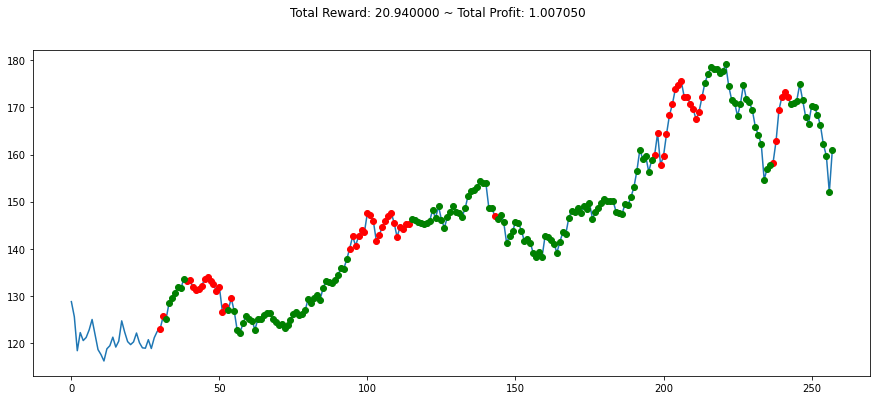

In [34]:
# Test Set Evaluation
env = MyCustomEnv(df=df, window_size=window_frame, frame_bound=test_frame)
dqn.test(env, nb_episodes=1, visualize=False, verbose=0)

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()